In [1]:
### Libraries

In [3]:
import pandas as pd
pd.set_option("display.precision",3)
import numpy as np
np.set_printoptions(precision=3,suppress=True)
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.12.0


DATA Creation

In [5]:
#Inputs range
obs = 1000
S_min = 1
S_max = 1000
K_min = 0.8 # as a percent of stock price
K_max = 1.2 # as a percent of stock price
t_min = 0.1
t_max = 10
r_min = 0.001
r_max = 0.1
sd_min = 0.001
sd_max = 0.3

In [7]:
# Inputs dataframe
%%time
data = pd.DataFrame( columns = ["S0", "K", "t", "r", "sd"])
data["S0"] = np.random.uniform(low=S_min, high=S_max, size=obs)
data["K"] = np.multiply(np.random.uniform(low=K_min, high=K_max, size=obs), data["S0"])
data["t"] = np.random.uniform(low=t_min, high=t_max, size=obs)
data["r"] = np.random.uniform(low=r_min, high=r_max, size=obs)
data["sd"] = np.random.uniform(low=sd_min, high=sd_max, size=obs)
print(data)

          S0         K      t      r     sd
0    876.553   725.622  3.664  0.068  0.126
1    202.077   195.602  5.910  0.096  0.042
2     84.489   100.295  2.861  0.065  0.155
3    629.895   692.523  7.771  0.008  0.287
4    434.147   401.997  8.214  0.098  0.166
..       ...       ...    ...    ...    ...
995  510.454   447.763  6.073  0.059  0.223
996  193.149   221.309  3.952  0.018  0.124
997  482.178   425.856  3.164  0.018  0.045
998  958.236  1051.417  4.397  0.076  0.027
999  515.151   456.055  5.661  0.053  0.088

[1000 rows x 5 columns]
CPU times: user 13.6 ms, sys: 971 µs, total: 14.6 ms
Wall time: 21.6 ms


In [8]:
# Descriptive statistcs
data.describe()

,S0,K,t,r,sd
count,1000.000,1000.000,1000.000,1000.000,1000.000
mean,494.529,492.660,5.030,0.050,0.148
std,284.280,291.593,2.836,0.029,0.087
min,1.696,1.687,0.103,0.001,0.002
25%,255.958,253.643,2.631,0.026,0.074
50%,478.074,466.226,4.875,0.049,0.142
75%,739.123,727.987,7.553,0.075,0.225
max,998.146,1169.742,9.978,0.100,0.300



# BLACK-SCHOLES MODEL (outputs: DNN labels)


In [9]:
# B-S model
data["d1"] = (np.log(data["S0"]/data["K"]) + (data['r']+0.5*data["sd"]**2)*data["t"]) / (data["sd"]*data["t"]**0.5)
data["d2"]  = data["d1"] - data["sd"]*data["t"]**0.5
data["c"] = data["S0"]*norm.cdf(data["d1"]) - data["K"]*np.exp(-data["r"]*data["t"])*norm.cdf(data["d2"])
data["c"] = (1+np.random.standard_normal(size=len(data["c"]))/20)*data["c"] # adding noise to c (68% of times +/-5%; 95% of times +/-10%; 99.7% of times +/-10%; )
data.drop(["d1", "d2"],axis=1, inplace=True)
data

,S0,K,t,r,sd,c
0,876.553,725.622,3.664,0.068,0.126,330.939
1,202.077,195.602,5.910,0.096,0.042,97.738
2,84.489,100.295,2.861,0.065,0.155,9.631
3,629.895,692.523,7.771,0.008,0.287,177.295
4,434.147,401.997,8.214,0.098,0.166,287.467
...,...,...,...,...,...,...
995,510.454,447.763,6.073,0.059,0.223,225.006
996,193.149,221.309,3.952,0.018,0.124,13.634
997,482.178,425.856,3.164,0.018,0.045,85.058
998,958.236,1051.417,4.397,0.076,0.027,210.595


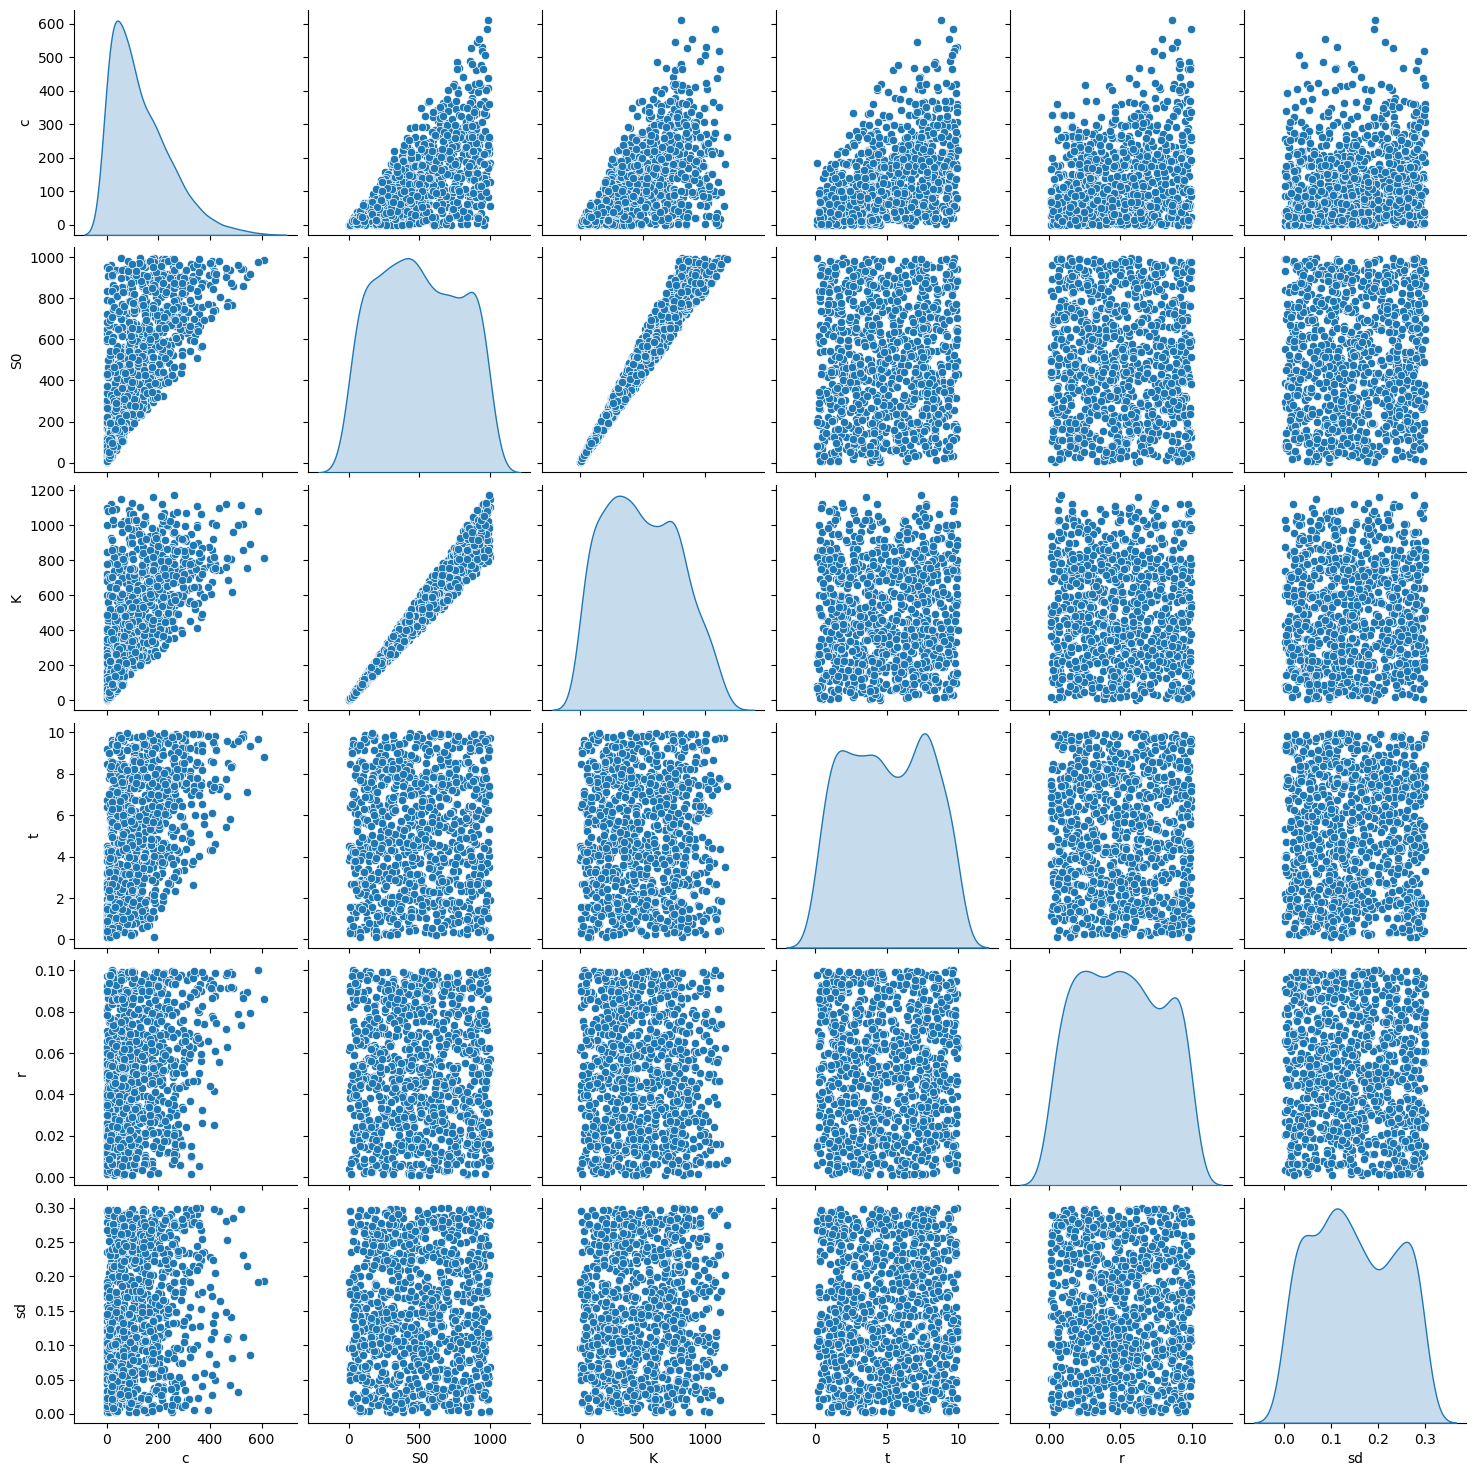

In [10]:
# Inspect data
sns.pairplot(data[['c', 'S0', 'K', 't', 'r', 'sd']], diag_kind='kde')

PREPROCESSING

In [11]:
# Train-Test split
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

train_dataset

,S0,K,t,r,sd,c
993,521.446,521.581,6.687,0.014,0.029,52.524
859,79.409,65.161,9.382,0.064,0.004,42.136
298,147.271,125.920,0.566,0.076,0.070,24.247
553,830.869,708.365,2.323,0.069,0.011,231.882
672,70.636,65.687,1.591,0.018,0.152,9.061
...,...,...,...,...,...,...
117,890.721,903.744,2.188,0.057,0.256,177.262
464,128.782,147.175,7.358,0.085,0.262,62.919
25,226.096,202.386,3.430,0.062,0.105,63.561
110,484.157,460.451,7.347,0.013,0.014,65.034


In [12]:
# Features-Labels separation
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('c')
test_labels = test_features.pop('c')

train_labels

993     52.524
859     42.136
298     24.247
553    231.882
672      9.061
        ...   
117    177.262
464     62.919
25      63.561
110     65.034
149    119.125
Name: c, Length: 800, dtype: float64

In [13]:
# Normalization (standardization of features)
normalizer = preprocessing.Normalization() #creates the layer
normalizer.adapt(np.array(train_features)) #fit it to the data
pd.DataFrame(normalizer(train_features).numpy(), columns=train_features.columns).describe() #check the normalization

,S0,K,t,r,sd
count,8.000e+02,8.000e+02,8.000e+02,8.000e+02,8.000e+02
mean,1.508e-07,7.808e-08,-1.872e-07,-1.669e-08,4.768e-09
std,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00
min,-1.755e+00,-1.702e+00,-1.737e+00,-1.733e+00,-1.676e+00
25%,-8.412e-01,-8.299e-01,-8.452e-01,-8.585e-01,-8.410e-01
50%,-6.250e-02,-8.352e-02,-6.169e-02,-9.458e-03,-7.387e-02
75%,8.559e-01,8.154e-01,8.986e-01,8.576e-01,8.950e-01
max,1.752e+00,2.253e+00,1.752e+00,1.732e+00,1.719e+00


LINEAR REGRESSION

In [14]:
#Model Definition
linear_model = tf.keras.Sequential([
    normalizer, #normalization layer
    layers.Dense(units=1) #linear regression layer (units = 1)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [15]:
#Model Compilation
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [16]:
#Model Training
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 8.01 s, sys: 312 ms, total: 8.33 s
Wall time: 11.3 s


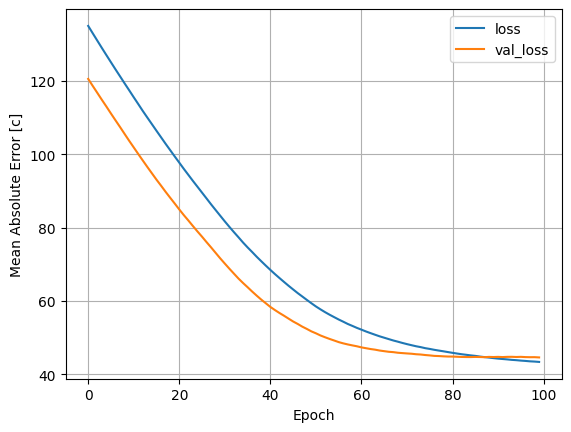

In [17]:
# Useful function to plot the loss function of the trained model
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error [c]')
  plt.legend()
  plt.grid(True)

#Plot loss
plot_loss(history)

In [18]:
#Collect results for later
test_results = pd.DataFrame(data=[], columns=[])
test_results['linear_model'] = [linear_model.evaluate(
    test_features, test_labels, verbose=0)]

In [19]:
#Print Coefficients after trining
Coefficients = pd.DataFrame(index=data.columns.to_list()[:-1])
Coefficients["Coefficients"] = linear_model.layers[1].kernel.numpy()
Coefficients

,Coefficients
S0,71.827
K,-5.967
t,45.741
r,28.237
sd,19.584


DEEP NEURAL NETWORK

In [21]:
# Define and compile the model
DNN_model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1)
])

DNN_model.compile(loss='mean_absolute_error',
                  #loss='mean_absolute_percentage_error',
                  #loss='MeanSquaredLogarithmicError',
              optimizer=tf.keras.optimizers.Adam(0.001))
DNN_model.build(train_features.shape)
DNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                384       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                      

In [22]:
%%time
history = DNN_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
20/20 [==============================] - 2s 12ms/step - loss: 135.0101 - val_loss: 119.3700
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 123.6601 - val_loss: 91.6488
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 78.6785 - val_loss: 66.9678
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 52.1768 - val_loss: 48.4725
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 44.1649 - val_loss: 42.8083
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 40.8618 - val_loss: 41.8219
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 38.4841 - val_loss: 40.9134
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 36.8421 - val_loss: 36.5347
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 34.5912 - val_loss: 33.9057
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 31.8117 - val

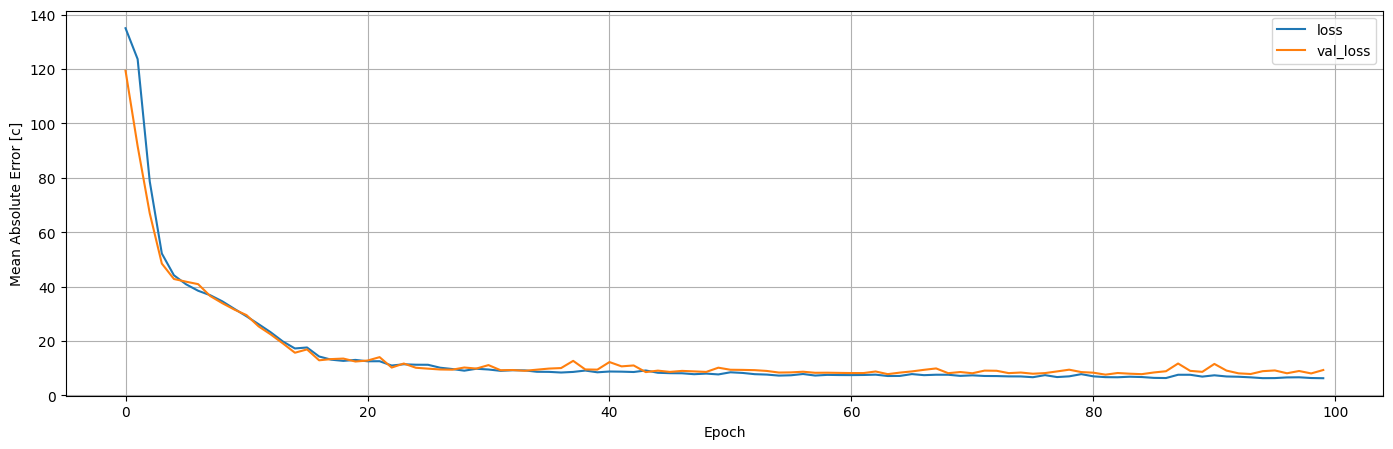

In [23]:
#Plot the loss
plt.figure(figsize = [17,5])
plot_loss(history)

In [24]:
#Collect Results
test_results['DNN_model'] = [DNN_model.evaluate(test_features, test_labels, verbose=0)]

#Linear model Vs DNN
test_results.index = ["Mean Absolute Error [c]"]
test_results.T

,Mean Absolute Error [c]
linear_model,43.344
DNN_model,9.330


DNN TESTING AND FURTHER ANALYSIS

7/7 [==============================] - 0s 2ms/step


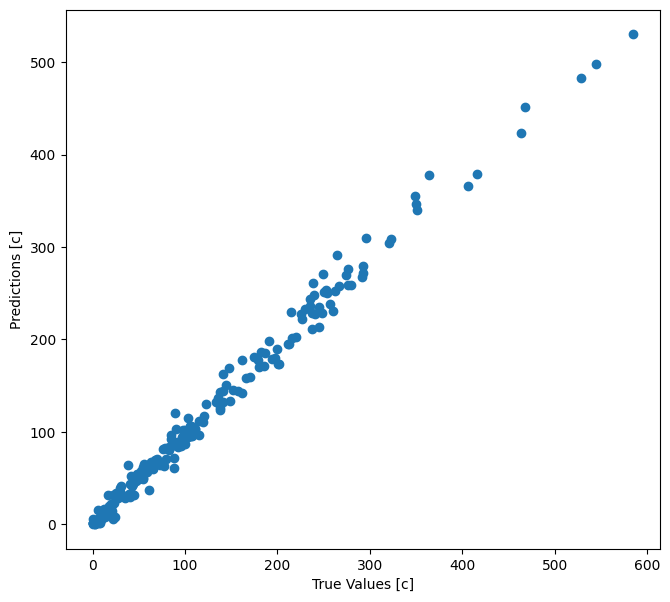

In [25]:
# Predicting test data
test_predictions = DNN_model.predict(test_features).flatten()
# Plot predicted vs true labels
plt.figure(figsize = [17,7])
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [c]')
plt.ylabel('Predictions [c]')
plt.show()

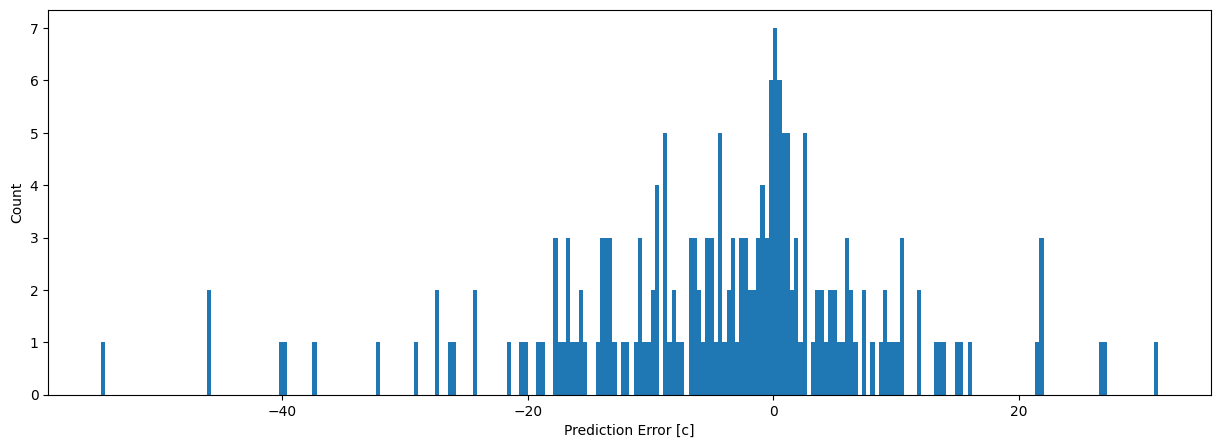

In [26]:
# Error histogram
plt.figure(figsize = [15,5])
error = test_predictions - test_labels
plt.hist(error, bins=250)
plt.xlabel('Prediction Error [c]')
_ = plt.ylabel('Count')

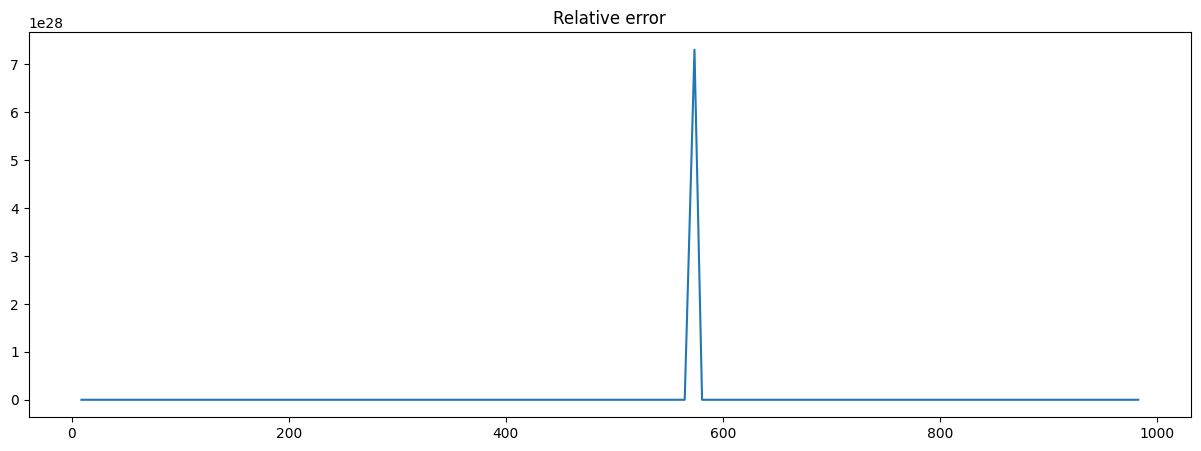

In [27]:
#Relative error
relative_error = np.divide(error,test_labels)
plt.figure(figsize = [15,5])
plt.plot(relative_error)
plt.title("Relative error")
plt.show()

In [28]:
#Descriptive statistics
relative_error.describe()

count    2.000e+02
mean     3.652e+26
std      5.165e+27
min     -1.020e+00
25%     -8.601e-02
50%     -2.978e-02
75%      3.770e-02
max      7.305e+28
Name: c, dtype: float64

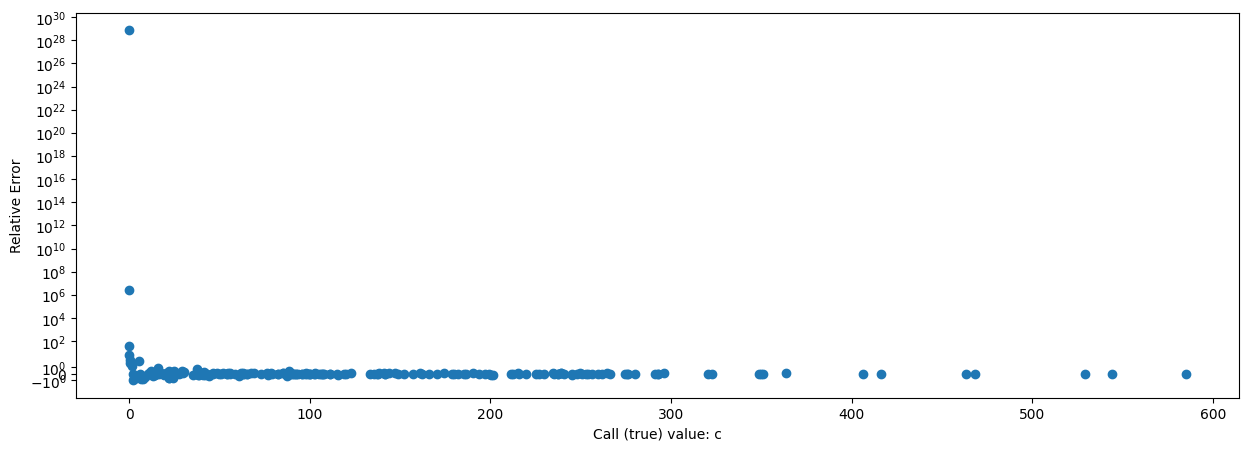

In [29]:
#Removing the infinite values
relative_error_corr = relative_error[abs(relative_error) != float("inf")]
test_labels_corr = test_labels[abs(relative_error) != float("inf")]
#Plot relative error vs call value
plt.figure(figsize=[15, 5])
plt.scatter(test_labels_corr, relative_error_corr)
plt.ylabel("Relative Error")
plt.xlabel("Call (true) value: c")
plt.yscale("symlog")
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


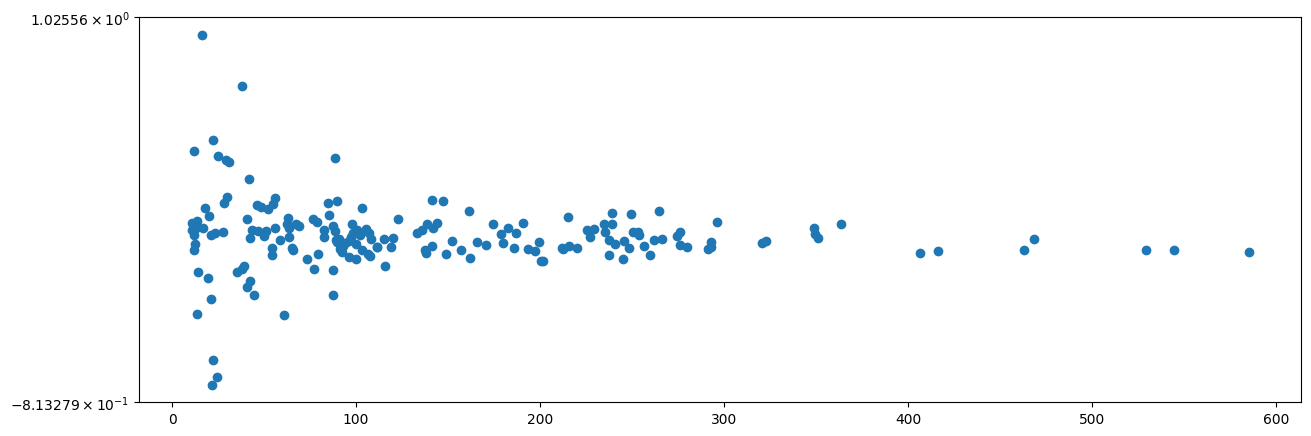

In [30]:
#Plot relative error vs call value for higher values of c
plt.figure(figsize=[15, 5])
plt.scatter(test_labels_corr[test_labels_corr >= 10], relative_error_corr[test_labels_corr >= 10])
plt.yscale("symlog")
plt.show()

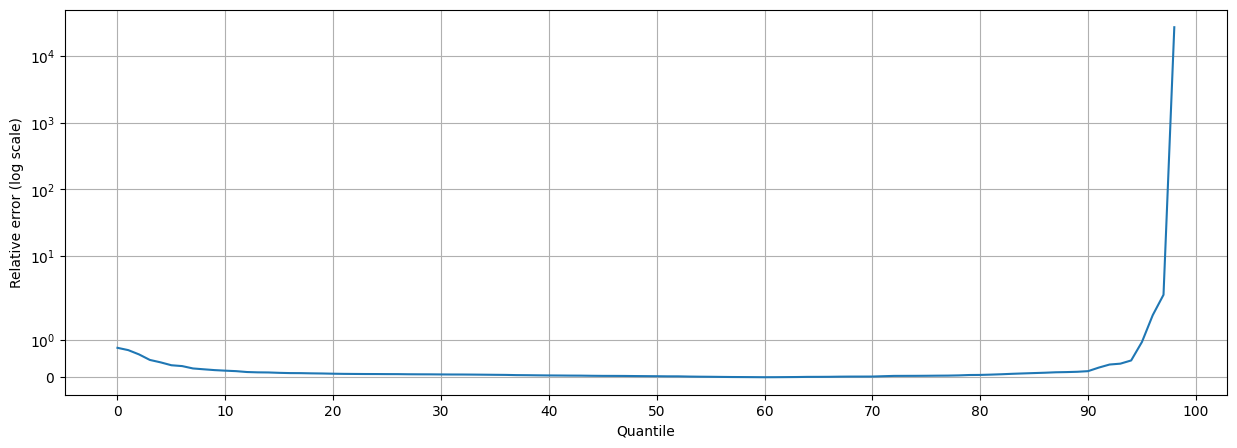

In [33]:
#Quantiles of relative error
quantile = np.zeros(100)
for qq in range(1, 100, 1):
  quantile[qq] = np.quantile( relative_error_corr,qq/100)
#Plot quantiles
plt.figure(figsize=[15, 5])
plt.plot(abs(quantile[1:]))
plt.yscale("symlog")
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Relative error (log scale)")
plt.xlabel("Quantile")
plt.grid(True)
plt.show()

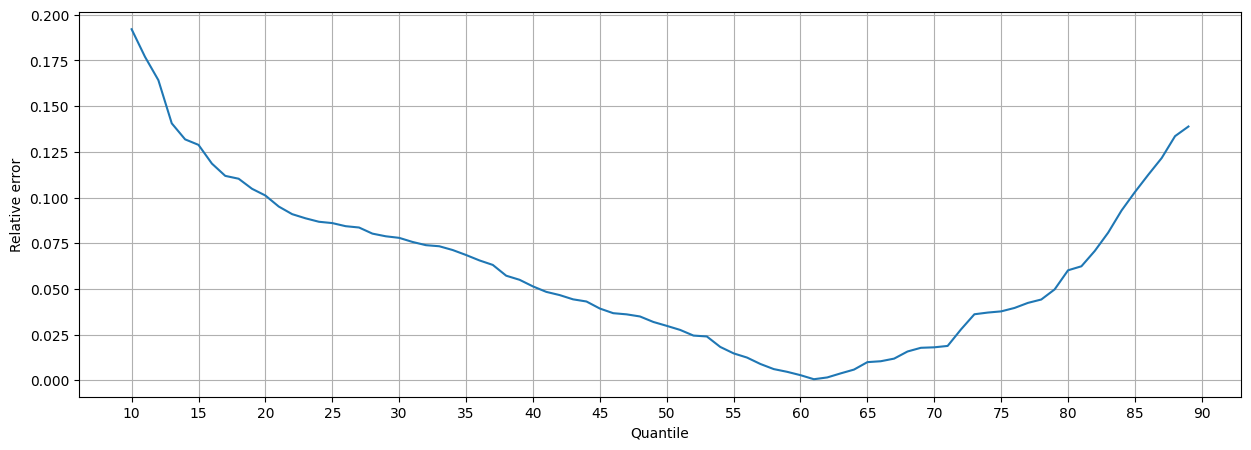

In [34]:
#Focus on quantile
x = 10
plt.figure(figsize=[15, 5])
plt.plot(range(x, 100-x), (abs(quantile[x:100-x])))
#plt.yscale("Log")
#plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Relative error")
plt.xlabel("Quantile")
plt.grid(True)
plt.show()

THE END